#Import Module

In [3]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from textblob import TextBlob

# Cleaning & Labeling Data

### Membersihkan teks review dari noise serta mengelompokkan score ke dalam label sentimen.

In [4]:
# Download resource VADER
nltk.download('vader_lexicon')

# Load Data
df = pd.read_csv('sololearn_raw.csv')


# Kamus sentimen
lexicon = {
    "positif": [
        "bagus", "mantap", "keren", "cepat", "baik", "menarik", "mudah", "bantu", "berguna", "suka",
        "top", "hebat", "canggih", "fitur", "gratis", "responsif", "nyaman", "stabil", "lancar", "terbaik",
        "simpel", "rekomendasi", "terpercaya", "menyenangkan", "efisien", "praktis", "seru", "powerful",
        "akurat", "update", "komplit", "memuaskan", "asik", "user-friendly", "inovatif", "solutif"
    ],
    "negatif": [
        "jelek", "buruk", "lemot", "error", "parah", "tidak", "susah", "payah", "bug", "iklan",
        "hang", "macet", "bosan", "ribet", "crash", "lemot", "gagal", "hilang", "lambat", "kurang",
        "lag", "berhenti", "mengecewakan", "aneh", "berulang", "force close", "ngulang", "fitur hilang",
        "susah login", "iklan banyak", "bikin kesel", "nggak bisa", "sering error", "tidak sesuai"
    ],
    "netral": [
        "biasa", "oke", "standar", "cukup", "lumayan", "normal", "seadanya", "ya gitu", "so-so", "lumrah",
        "gitu aja", "not bad", "seperti biasa", "tidak masalah", "standard"
    ]
}

# Inisialisasi VADER
vader = SentimentIntensityAnalyzer()

# Fungsi skor dari VADER
def get_vader_score(text):
    return vader.polarity_scores(text)['compound']

# Ekstraksi fitur dan pelabelan
def label_sentiment_vader_lexicon(row):
    score = row['score']  # Rating
    text = row['content']  # Komentar
    vader_score = get_vader_score(text)  # Skor VADER
    lexicon_sentiment = lexicon_sentiment_from_text(text)  # Pelabelan lexicon

    # Evaluasi lexicon dan VADER
    avg_sentiment = (vader_score + lexicon_sentiment_score(lexicon_sentiment)) / 2

    # Pelabelan sentimen
    if avg_sentiment > 0.05 and score >= 3:
        return 'positif'
    elif avg_sentiment < -0.05 and score <= 3:
        return 'negatif'
    else:
        return 'netral'

# Mengidentifikasi sentimen berdasarkan lexicon
def lexicon_sentiment_from_text(text):
    words = text.split()
    positive_count = sum(word in lexicon["positif"] for word in words)
    negative_count = sum(word in lexicon["negatif"] for word in words)

    if positive_count > negative_count:
        return "positif"
    elif negative_count > positive_count:
        return "negatif"
    else:
        return "netral"

# Menghitung skor sentimen lexicon
def lexicon_sentiment_score(sentiment):
    if sentiment == "positif":
        return 1
    elif sentiment == "negatif":
        return -1
    else:
        return 0

# Pelabelan sentimen
df['sentiment'] = df.apply(label_sentiment_vader_lexicon, axis=1)

# Hasil dan Simpan Data
print(df['sentiment'].value_counts())
df[['content', 'sentiment']].to_csv('sentiment_labelled_data.csv', index=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment
positif    12400
netral      7200
negatif      400
Name: count, dtype: int64


# Ekstraksi Fitur & Split Data

### Mengekstrak fitur dari teks menggunakan TF-IDF serta membagi dataset jadi training & testing.

In [5]:
# Fitur dan label
X = df['content']  # Data teks
y = df['sentiment']  # Label sentimen

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set: {X_train.shape[0]} | Test set: {X_test.shape[0]}")

Train set: 16000 | Test set: 4000


# Training Model

### - Logistic Regression
### - Multinomial Naive Bayes
### - Support Vector Machine (SVM)

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have num

In [13]:
# Membangun dan melatih model Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Prediksi menggunakan data test
y_pred = logreg.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print("\n=== Classification Report (Semua Data) ===")
print("Skema 1 - Logistic Regression + TF-IDF + 80/20")
print(f"Akurasi Model: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


=== Classification Report (Semua Data) ===
Skema 1 - Logistic Regression + TF-IDF + 80/20
Akurasi Model: 0.9892
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        80
      netral       1.00      0.97      0.98      1440
     positif       0.98      1.00      0.99      2480

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [14]:
!pip install gensim nltk scikit-learn numpy

In [15]:
!pip install numpy==1.24.4 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which 

In [1]:
!pip install --upgrade gensim

In [8]:
# Load data
df = pd.read_csv('sentiment_labelled_data.csv')

# Tokenisasi dasar
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Tokenisasi untuk Word2Vec
tokenized_data = df['content'].apply(tokenize)

# Train Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi ekstraksi fitur dari teks
def get_word2vec_features(text):
    tokens = tokenize(text)
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Ubah semua teks ke vektor
X_word2vec = np.array([get_word2vec_features(text) for text in df['content']])

# Encode label (string → angka)
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# Train model ke seluruh data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_word2vec, y)

# Prediksi ulang semua data
y_pred = clf.predict(X_word2vec)

# Evaluasi
print("\n=== Classification Report (Semua Data) ===")
print("Skema 2 - Random Forest + Word2Vec + 80/20")
print("Akurasi Model:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred, target_names=le.classes_))


=== Classification Report (Semua Data) ===
Skema 2 - Random Forest + Word2Vec + 80/20
Akurasi Model: 0.99
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       400
      netral       1.00      0.97      0.99      7200
     positif       0.98      1.00      0.99     12400

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [9]:
# Label encoding
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# TF-IDF vektor
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])

# 70/30 split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y)

# Training model
rf_model_tfidf = RandomForestClassifier()
rf_model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Evaluasi
y_pred_tfidf = rf_model_tfidf.predict(X_test_tfidf)
print("\n=== Classification Report (Semua Data) ===")
print("Skema 3 - Random Forest + TF-IDF + 70/30")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=le.classes_))


=== Classification Report (Semua Data) ===
Skema 3 - Random Forest + TF-IDF + 70/30
Accuracy: 0.9903333333333333
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       120
      netral       1.00      0.97      0.99      2160
     positif       0.98      1.00      0.99      3720

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



# Visualisasi data distribusi sentimen

<ipython-input-10-2a9b357455da>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='sentiment', y='count', order=order, palette="deep")


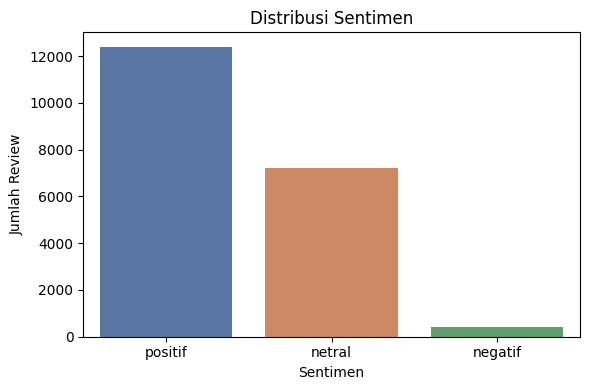

sentiment
positif    12400
netral      7200
negatif      400
Name: count, dtype: int64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah
sentiment_counts = df['sentiment'].value_counts()

# Buat DataFrame baru agar seaborn baca lebih stabil
plot_df = sentiment_counts.reset_index()
plot_df.columns = ['sentiment', 'count']

# Urutkan manual kalau perlu
order = ['positif', 'netral', 'negatif']

# Visualisasi
plt.figure(figsize=(6, 4))
sns.barplot(data=plot_df, x='sentiment', y='count', order=order, palette="deep")
plt.title("Distribusi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.tight_layout()
plt.show()
print(df['sentiment'].value_counts())

## Distribusi Sentimen pada Review Aplikasi

Grafik batang di atas menunjukkan distribusi jumlah review berdasarkan kategori sentimen: **positif**, **netral**, dan **negatif**.

---

### Observasi:

- **Sentimen Positif** mendominasi secara signifikan, dengan jumlah lebih dari **12.400 review**.
- **Sentimen Netral** adalah yang paling sedikit, hanya sekitar **7.200 review**.
- **Sentimen Negatif** hanya menyumbang sebagian kecil dari total review, yaitu sekitar **400 review**.


### Insight:

- Dominasi sentimen **positif** menandakan bahwa sebagian besar pengguna merasa **puas dan terbantu** dengan aplikasi ini.
- Jumlah review **negatif** dan **netral** yang relatif sedikit bisa mengindikasikan dua hal:
  1. Aplikasi ini memang memiliki kualitas baik secara umum.
  2. Atau, ada potensi bias dari pengguna yang hanya akan meninggalkan ulasan saat puas.




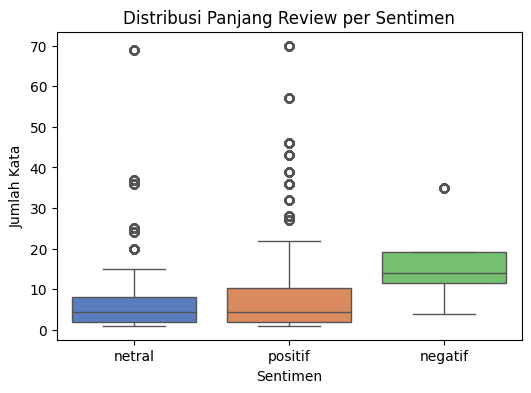

In [12]:
# Distribusi Panjang Review per Sentimen
df['review_length'] = df['content'].apply(lambda x: len(x.split()))

# Visualisasi boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x='sentiment', y='review_length', data=df, hue='sentiment', palette="muted", legend=False)
plt.title("Distribusi Panjang Review per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Kata")
plt.show()

## Distribusi Panjang Review per Sentimen

Boxplot di atas menunjukkan distribusi panjang review (berdasarkan jumlah kata) untuk masing-masing kategori sentimen: **positif**, **netral**, dan **negatif**.

---

### Observasi:

- **Review Positif**:
  - Mayoritas review positif memiliki panjang yang relatif pendek, dengan median sekitar 6–7 kata.
  - Terdapat sejumlah outlier dengan panjang yang sangat besar (di atas 20 kata), meskipun tidak sebanyak sentimen negatif. Ini mengindikasikan bahwa pengguna yang puas cenderung memberikan ulasan yang singkat dan to the point.


- **Review Netral**:
  - Panjang review netral memiliki variasi paling kecil, dengan median di sekitar 6 kata.
  - Sebagian besar review berada di antara 4–10 kata, dan hanya sedikit outlier.
  - Hal ini menunjukkan bahwa pengguna netral cenderung memberikan ulasan yang singkat, deskriptif dan tidak emosional.

- **Review Negatif**:
  - Menariknya, review negatif justru memiliki panjang lebih besar, dengan median di sekitar 10–12 kata.
  - Terdapat cukup banyak outlier yang melebihi 20 kata. Ini mengindikasikan bahwa pengguna cenderung memberikan penjelasan lebih detail saat memberikan ulasan negatif, mungkin karena ingin menyampaikan kritik atau keluhan secara lengkap.






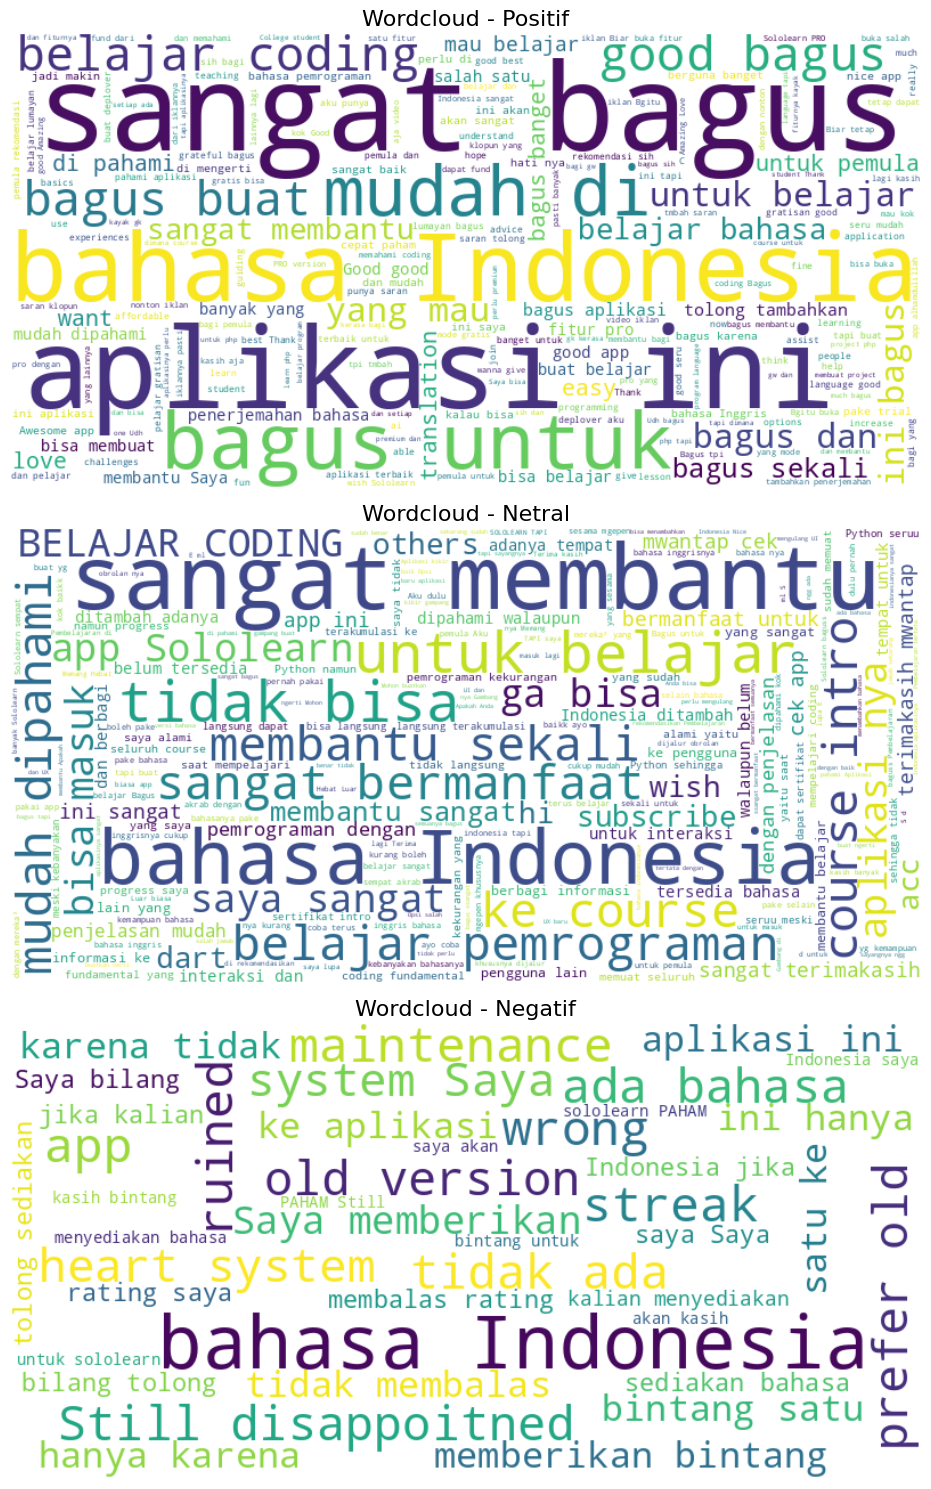

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud per label sentimen
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, label in enumerate(['positif', 'netral', 'negatif']):
    text = " ".join(df[df['sentiment'] == label]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Wordcloud - {label.capitalize()}", fontsize=16)

plt.tight_layout()
plt.show()

## Visualisasi Wordcloud Berdasarkan Sentimen

Berikut adalah visualisasi wordcloud yang menampilkan kata-kata paling sering muncul dalam ulasan pengguna, yang telah dikelompokkan berdasarkan sentimen: positif, netral, dan negatif.

---  

### Wordcloud - Positif
Kata-kata dominan:
**"bahasa indonesia"**, **"sangat"**, **"bagus"**, **"untuk belajar"**, **"aplikasi ini"**, **"membantu"**, **"mudah dipahami"**, **"coding"**.

Ulasan positif didominasi oleh komentar yang menekankan kemudahan penggunaan, kualitas materi belajar, dan kehadiran bahasa Indonesia dalam aplikasi. Kata **"sangat bagus"**, **"membantu"** dan **"mudah dipahami"** muncul berulang, menandakan bahwa pengguna merasa puas terutama dalam proses belajar mandiri.

Beberapa juga menyebutkan fitur pembelajaran coding yang menarik bagi pemula, dan menghargai opsi belajar dalam bahasa lokal. Sentimen ini memperlihatkan bahwa aplikasi telah berhasil memberikan pengalaman belajar yang menyenangkan dan bermanfaat.



### Wordcloud - Netral

Kata-kata dominan:
**"bahasa indonesia"**, **"aplikasi nya"**, **"membantu"**, **"course"**, **"pemrograman"**, **"tidak bisa"**, **"masuk"**, **"coding"**, **"bisa"**, **"belajar"**.

Review netral mencerminkan ulasan yang bersifat informasional dan seimbang, tanpa emosi yang terlalu kuat. Kata-kata seperti **“membantu sekali”** dan **“aplikasinya baik”** muncul bersamaan dengan ungkapan seperti **“tidak bisa masuk”** atau **“fitur kurang lengkap”**.

Ulasan ini menunjukkan bahwa pengguna mengakui manfaat aplikasi, tetapi juga mengutarakan beberapa kendala teknis ringan seperti akses ke course, login, atau fitur yang terbatas.



### Wordcloud - Negatif

Kata-kata dominan:
**"bahasa indonesia"**, **"tidak ada"**, **"app"**, **"whats wrong"**, **"ruined"**, **"prefer old"**, **"maintenance"**, **"system"**, **"cant"**, **"still disappointed"**, **"heart"**, **"streak"**.

Review negatif lebih banyak mengandung keluhan atau kritik, terutama terkait masalah teknis, fitur yang hilang, dan ketidakpuasan terhadap versi baru aplikasi. Munculnya kata seperti **“ruined”**, **“prefer old”** dan **“still disappointed”** menunjukkan adanya pengguna yang merasa pengalaman penggunaan aplikasi menurun.

Isu teknis yang sering muncul termasuk fitur streak yang terganggu, masalah sistem/maintenance, dan tidak tersedianya bahasa Indonesia pada beberapa bagian, yang dianggap cukup mengganggu proses belajar.

In [19]:
# Load model
df = pd.read_csv('sentiment_labelled_data.csv')

# Tokenisasi dasar
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Fungsi ekstraksi fitur dari teks (Word2Vec)
def get_word2vec_features(text):
    tokens = tokenize(text)
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Fungsi untuk analisis sentimen manual
def analisis_sentimen_manual(kalimat):
    vec = get_word2vec_features(kalimat).reshape(1, -1)
    prediksi = clf.predict(vec)
    sentiment = le.inverse_transform(prediksi)[0]
    return sentiment

# Input manual
kalimat_user = input("Masukkan kalimat untuk analisis sentimen: ")
hasil_sentimen = analisis_sentimen_manual(kalimat_user)

print(f"\nKalimat: {kalimat_user}")
print(f"Prediksi Sentimen: {hasil_sentimen.capitalize()}")

Masukkan kalimat untuk analisis sentimen: ruined

Kalimat: ruined
Prediksi Sentimen: Negatif


In [17]:
!pip freeze > requirements.txt